<a href="https://colab.research.google.com/github/rkatophys/contour-calculation/blob/main/contour_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial of Contour Calculation
This notebook is designed to compute and visualize the contours of a gravitational wave signal on the celestial sphere.
It mainly utilizes [enterprise](https://github.com/nanograv/enterprise), [enterprise_extensions](https://github.com/nanograv/enterprise_extensions) and [JAX](https://github.com/jax-ml/jax), to estimate parameter uncertainties in pulsar timing array analyses.

## 1. Required Libraries and Environment Setup
- Install enterprise and enterprise_extensions.
- Download the necessary data and scripts from our github repository.

In [1]:
!apt-get install libsuitesparse-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparseconfig5 libumfpack5
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3 libcolamd2 libcxsparse3
  libgraphblas-dev libgraphblas6 libklu1 libldl2 libmetis5 libmongoose2
  librbio2 libsliplu1 libspqr2 libsuitesparse-dev libsuitesparseconfig5
  libumfpack5
0 upgraded, 19 newly installed, 0 to remove and 35 not upgraded.
Need to get 22.4 MB of archives.
After this operation, 169 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libsuitesparseconfig5 amd64 1:5.10.1+dfsg-4build1 [10.4 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libamd2 amd64 1:5

In [2]:
!pip install --upgrade numpy==2.0 scipy scikit-sparse enterprise_extensions enterprise-pulsar --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 270.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.6/175.6 kB 343.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 302.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 395.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 289.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 158.0 MB/s eta 0:00:00
  Created wheel for scikit-sparse: filename=scikit_sparse-0.4.16-cp311-cp311-linux_x86_64.whl size=749324 sha256=ea44035730d333a2850760cc99e697c15c0ae65a446da3fffb99d365b5dfde00
  Stored in directory: /tmp/pip-ephem-wheel-cache-

In [3]:
!git clone https://github.com/rkatophys/contour-calculation.git contourcalc

Cloning into 'contourcalc'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 23 (delta 6), reused 19 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (23/23), 222.44 KiB | 2.29 MiB/s, done.
Resolving deltas: 100% (6/6), done.


## 2. Imports and Script Preparation

- Importing standard packages.
- Creating wrapper scripts (utils_jnp.py, deterministic_jnp.py) that convert original enterprise functions to be compatible with JAX. We do not guarantee the behavior of functions other than those used in this context. The reference script after conversion is located in the contourcalc/sample-script directory.
- Importing the modified JAX-compatible scripts.

In [4]:
%load_ext autoreload
%autoreload 2

import os
os.environ["JAX_ENABLE_X64"] = "True"
import ast
import numpy as np
import scipy.linalg as linalg
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import joblib
from healpy.newvisufunc import projview, newprojplot
from copy import copy
import itertools
import arviz as az
import mpmath
mpmath.mp.dps = 1000
import jax
import jax.numpy as jnp
import inspect
import re

from enterprise_extensions import deterministic
from enterprise.signals import utils

In [5]:
# Get the source code of the enterprise function and apply replacement
text = inspect.getsource(utils).replace("import numpy as np", "import jax.numpy as np")
# Write the modified source code to file
with open("utils_jnp.py", "w") as file:
    file.write(text)

# Get the source code of the enterprise_extensions function and apply replacement
text = inspect.getsource(deterministic)

# Define replacement rules (order matters)
replacements = [
    ("import numpy as np", "import jax.numpy as np"),
    (
        "from enterprise.signals import deterministic_signals, parameter, signal_base, utils",
        "from enterprise.signals import deterministic_signals, parameter, signal_base\nimport utils"
    ),
    ("utils", "utils_jnp"),
    ("cos_gwtheta=0,", "gwtheta=0,"),
    ("cos_inc=0,", "inc=0,"),
    ("gwtheta = np.arccos(cos_gwtheta)", ""),
    ("inc = np.arccos(cos_inc)", ""),
    ("if p_dist > 0:", "if True:")
]

# Apply all replacements
for old, new in replacements:
    text = text.replace(old, new)

# Write the modified source code to file
with open("deterministic_jnp.py", "w") as file:
    file.write(text)


In [6]:
import utils_jnp
import deterministic_jnp
import contourcalc.script.pta_contour as pta_contour

## 3. Setting global variables

In [7]:
white_seed = 0           # Seed for the white noise random number generator
white_sigma = 10 * 1e-9  # Standard deviation of white noise [seconds]

period = 12.5            # Observation duration of the pulsar [years]
cadence = 3              # Observation cadence of the pulsar [weeks]

calc_snr = False         # Flag to calculate approximate SNR or not
folder = "cov_mean"      # Output folder name

## 4. Loading Pulsar Data
The dataset includes all pulsars from NANOGrav, EPTA, and PPTA.
For some of these pulsars, distances have been accurately measured using VLBI.

In [8]:
# Load pulsar data and distance data from CSV files
datadf = pd.read_csv("./contourcalc/data/psr_data_list.csv")   # Basic information such as RA/Dec
distdf = pd.read_csv("./contourcalc/data/psr_dist_list.csv")   # Distance and its uncertainty information form VLBI

# Keep only the necessary columns in distdf and rename them (for clarity after merging)
distdf_renamed = distdf.rename(columns={
    "NOW +σd [pc]": "pdist_sigma_now",
    "SKA +σd [pc]": "pdist_sigma_ska"
})[["psr", "pdist_sigma_now", "pdist_sigma_ska"]]

# Merge the two dataframes on "psr" (pulsar name) using a left join based on datadf
# After merging, sort by "NOW +σd [pc]" (uncertainty of current distance)
merged_df = pd.merge(datadf, distdf_renamed, on="psr", how="left").sort_values("pdist_sigma_now")

# Extract each column as NumPy arrays (useful for fast computation and later processing)
psr_names = merged_df["psr"].to_numpy()                      # List of pulsar names
psr_radecs = merged_df[["ra", "dec"]].to_numpy()             # Right ascension and declination [rad]
psr_pdists_sigma_now = merged_df["pdist_sigma_now"].to_numpy()  # current distance uncertainty [pc]
psr_pdists_sigma_ska = merged_df["pdist_sigma_ska"].to_numpy()  # SKA distance uncertainty [pc]

## 4. Setting Noise and Pulsar Parameters
- Generate seed values for the white noise of each pulsar.
- Generate all sky locations of the gravitational wave source on the celestial sphere.
- Set parameters of the gravitational wave.
- Set parameters of the pulsar distances.
- Create objects for each pulsar containing several types of information.

In [9]:
# Get the number of pulsars (total count of pulsar names)
lenpsrs = len(psr_names)

# Generating white noise seed values for each pulsar
psr_seeds = np.random.default_rng(seed=0).permutation(lenpsrs)[merged_df.index.to_numpy()]

In [10]:
# Setting the number of pixels dividing the celestial sphere
NSIDE = 6
NPIX = hp.nside2npix(NSIDE)

# Pixel indices
pixel_indices = np.arange(NPIX)

# Convert pixel indices to spherical coordinates (theta, phi)
thetas, phis = hp.pix2ang(NSIDE, pixel_indices, nest=False)

In [11]:
# Set GW source parameters for the current pixel (angnum)
params_dict = {
    "gwtheta": thetas,  # GW source polar angle
    "gwphi": phis,      # GW source azimuthal angle
    "inc": 1.0,                 # inclination angle cosine
    "log10_mc": 9.0,            # log10 of chirp mass
    "log10_fgw": -8.0,          # log10 of GW frequency
    "log10_dist": 2.0,          # log10 of distance to GW source
    "phase0": 1.0,              # initial GW phase
    "psi": 1.0,                 # polarization angle
}

In [12]:
# Set default distance to 1.0 kpc and distance uncertainty to 0.1 kpc for all pulsars
pdists_dict = {
    psr_name: {"pdist": 1.0, "pdist_sigma": 0.1}  # 1000 pc = 1 kpc
    for psr_name in psr_names
}

# Override distance and uncertainty for J0437-4715 from merged_df (converted to kpc)
pdist0437_dict = {
    "J0437-4715": {
        "pdist": 1.0,
        "pdist_sigma": (
            merged_df.loc[merged_df["psr"] == "J0437-4715", "pdist_sigma_ska"].values[0] * 1e-3
        ),
    }
}

# Override distance and uncertainty for J0030+0451 from merged_df (converted to kpc)
pdist0030_dict = {
    "J0030+0451": {
        "pdist": 1.0,
        "pdist_sigma": (
            merged_df.loc[merged_df["psr"] == "J0030+0451", "pdist_sigma_ska"].values[0] * 1e-3
        ),
    }
}

# Update the default distances with the specific overrides
pdists_dict.update(pdist0437_dict)
pdists_dict.update(pdist0030_dict)

In [13]:
# Create a list of DummyPsr objects for each pulsar
psrs_list = []
for i in range(lenpsrs):
    psr = pta_contour.DummyPsr(
        psr_names[i],
        psr_radecs[i],
        psr_seeds[i],
        period=period,
        cadence=cadence,
        pdist=pdists_dict[psr_names[i]]["pdist"],
        pdist_sigma=pdists_dict[psr_names[i]]["pdist_sigma"],
        white_sigma=white_sigma,
        white_seed=white_seed,
    )
    psrs_list.append(psr)

# Convert the list of pulsars into a NumPy array
psrs = np.array(psrs_list)

## 5. Main Calculation
Compute contours for all pixels. The resulting means and covariances are saved as text files.

In [14]:
# Run loop_func in parallel over all pixels (indexed by angnum)
# n_jobs=1: run with a single worker (can increase if desired)
# Takes ~10 minutes to execute with calc_snr = False
result = joblib.Parallel(n_jobs=1, prefer="threads")(
    joblib.delayed(pta_contour.loop_func)(angnum, psrs, params_dict, white_sigma, folder, calc_snr) for angnum in range(len(phis))
)

## 6. Loading Calculation Results
Load the computed means and covariances.

In [15]:
means = []  # List to store mean vectors loaded from files
covs = []   # List to store covariance matrices loaded from files

for i in range(len(phis)):
    # Load the mean vector for the i-th pixel from file
    mean = np.loadtxt(f"{folder}/mean_{i}.txt")
    # Load the covariance matrix for the i-th pixel from file
    cov = np.loadtxt(f"{folder}/cov_{i}.txt")

    means.append(mean)  # Append loaded mean to the list
    covs.append(cov)    # Append loaded covariance to the list

## 7. Visualize Contour
Plot the contours themselves and their areas.

/usr/local/lib/python3.11/dist-packages/healpy/newvisufunc.py:535: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=left, right=right, top=top, bottom=bottom)


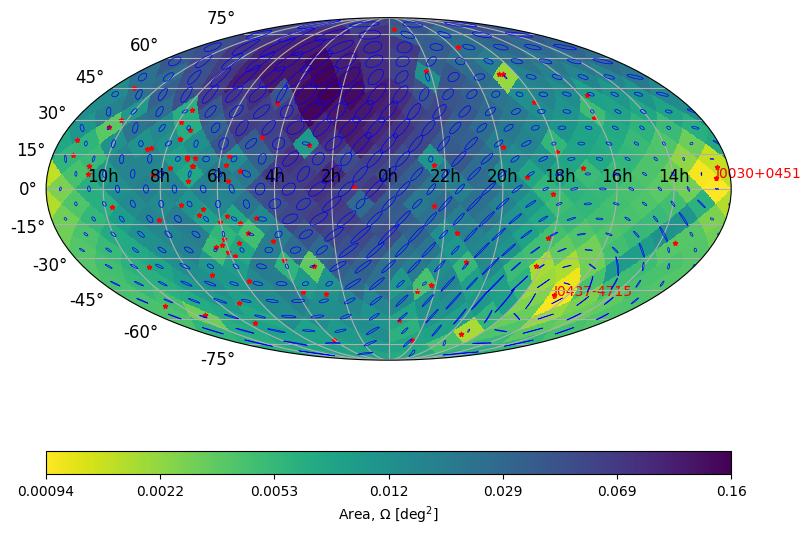

In [16]:
prob_area = mpmath.mpf("0.68")  # Probability for 68% confidence region
prob_contour = mpmath.mpf("1.0")-mpmath.mpf("1e-200")  # Nearly 100% probability for contour plotting

# Create a name of ra axis
time24s = 2 * (np.arange(12))[::-1]
timeh = np.roll([f"{str(time24)}h" for time24 in time24s], -5)[1:]

# List of all variable names (GW parameters + pulsar distances)
allvar = np.array(list(params_dict.keys()) + list(pdists_dict.keys()))

fig, ax = plt.subplots(figsize=[8, 16], rasterized=True, layout='constrained')

ellipses_list = []
areas_list = []
for i in range(len(phis)):
    var1, var2 = "gwphi", "gwtheta" # Variables on x-axis and y-axis

    # Extract the relevant 2D section of the mean and covariance matrix
    mask = (allvar == str(var1)) | (allvar == str(var2))
    mean2d = means[i][mask]
    cov2d = covs[i][mask][:, mask]

    # Reverse the order of the mean and variance if they do not match the order of var1 and var2.
    if np.all(np.where(allvar == str(var1)) > np.where(allvar == str(var2))):
        mean2d = mean2d[::-1]
        cov2d = cov2d[::-1, ::-1]

    phi, theta = mean2d

    # Rotate angles for plotting
    rotphi, rottheta = pta_contour.ang_rot(phi, theta)

    # Perform SVD on covariance to get ellipse orientation and size
    width, height, angle = pta_contour.get_ellipse_params_from_cov(cov2d)

    # Create ellipse for the probability contour
    ellipse = Ellipse(
        xy=[rotphi, rottheta],
        width=width * pta_contour.prob_chisq(prob_contour),
        height=height * pta_contour.prob_chisq(prob_contour),
        angle=angle,
        facecolor="none",
        edgecolor="blue",
        alpha=1.0,
        zorder=2.0,
        lw=0.5,
    )

    new_ellipse = copy(ellipse)

    # Calculate ellipse area for 68% confidence region
    area = np.pi * (width * pta_contour.prob_chisq(prob_area) / 2.0) * (height * pta_contour.prob_chisq(prob_area) / 2.0)
    ellipses_list.append(new_ellipse)
    areas_list.append(area)

# Calculate spherical area (deg^2)
properareas = np.array(areas_list) * (180.0 / np.pi) ** 2 * np.sin(thetas)

# Visualize with Mollweide projection
projview(
    properareas,
    coord=["G"],
    rot=(180, 0, 0),
    flip="astro",
    graticule=True,
    graticule_labels=True,
    projection_type="mollweide",
    longitude_grid_spacing=30,
    latitude_grid_spacing=15,
    custom_xtick_labels=timeh,
    hold=True,
    cbar=False,
    cmap="viridis_r",
    alpha=1.0,
    zorder=0.0,
    norm="log",
    extend="neither",
)

# Configure colorbar
im = fig.axes[0].collections[0]
cbar = plt.colorbar(
    im,
    ax=fig.axes[0],
    ticks=np.logspace(np.log10(np.min(properareas)), np.log10(np.max(properareas)), 7),
    format="{x:.2g}",
    location="bottom",
    orientation="horizontal",
    aspect=30,
    shrink=1.0,
)
cbar.ax.tick_params(labelsize=10)
cbar.set_label(label=r"Area, $\Omega$ $[{\rm deg}^2]$", size=10)

# Add ellipses to plot
ax = plt.gca()
for ellipse in ellipses_list:
    ax.add_patch(ellipse)

# Plot pulsar positions with red stars
for psr in psrs:
    pphi = psr.pixels[1]
    ptheta = psr.pixels[0]
    rotpphi, rotptheta = pta_contour.ang_rot(pphi, ptheta)
    ax.scatter(
        rotpphi,
        rotptheta,
        marker="*",
        facecolor="red",
        edgecolors="red",
        s=10,
        zorder=1.0,
    )
    # Display names for specific pulsars
    if psr.name in ["J0437-4715", "J0030+0451"]:
        ax.text(
            rotpphi,
            rotptheta,
            psr.name,
            size=10,
            color="red",
            zorder=1.0,
        )

plt.show()


## 8. Supplement
Plot the contours for all parameters."

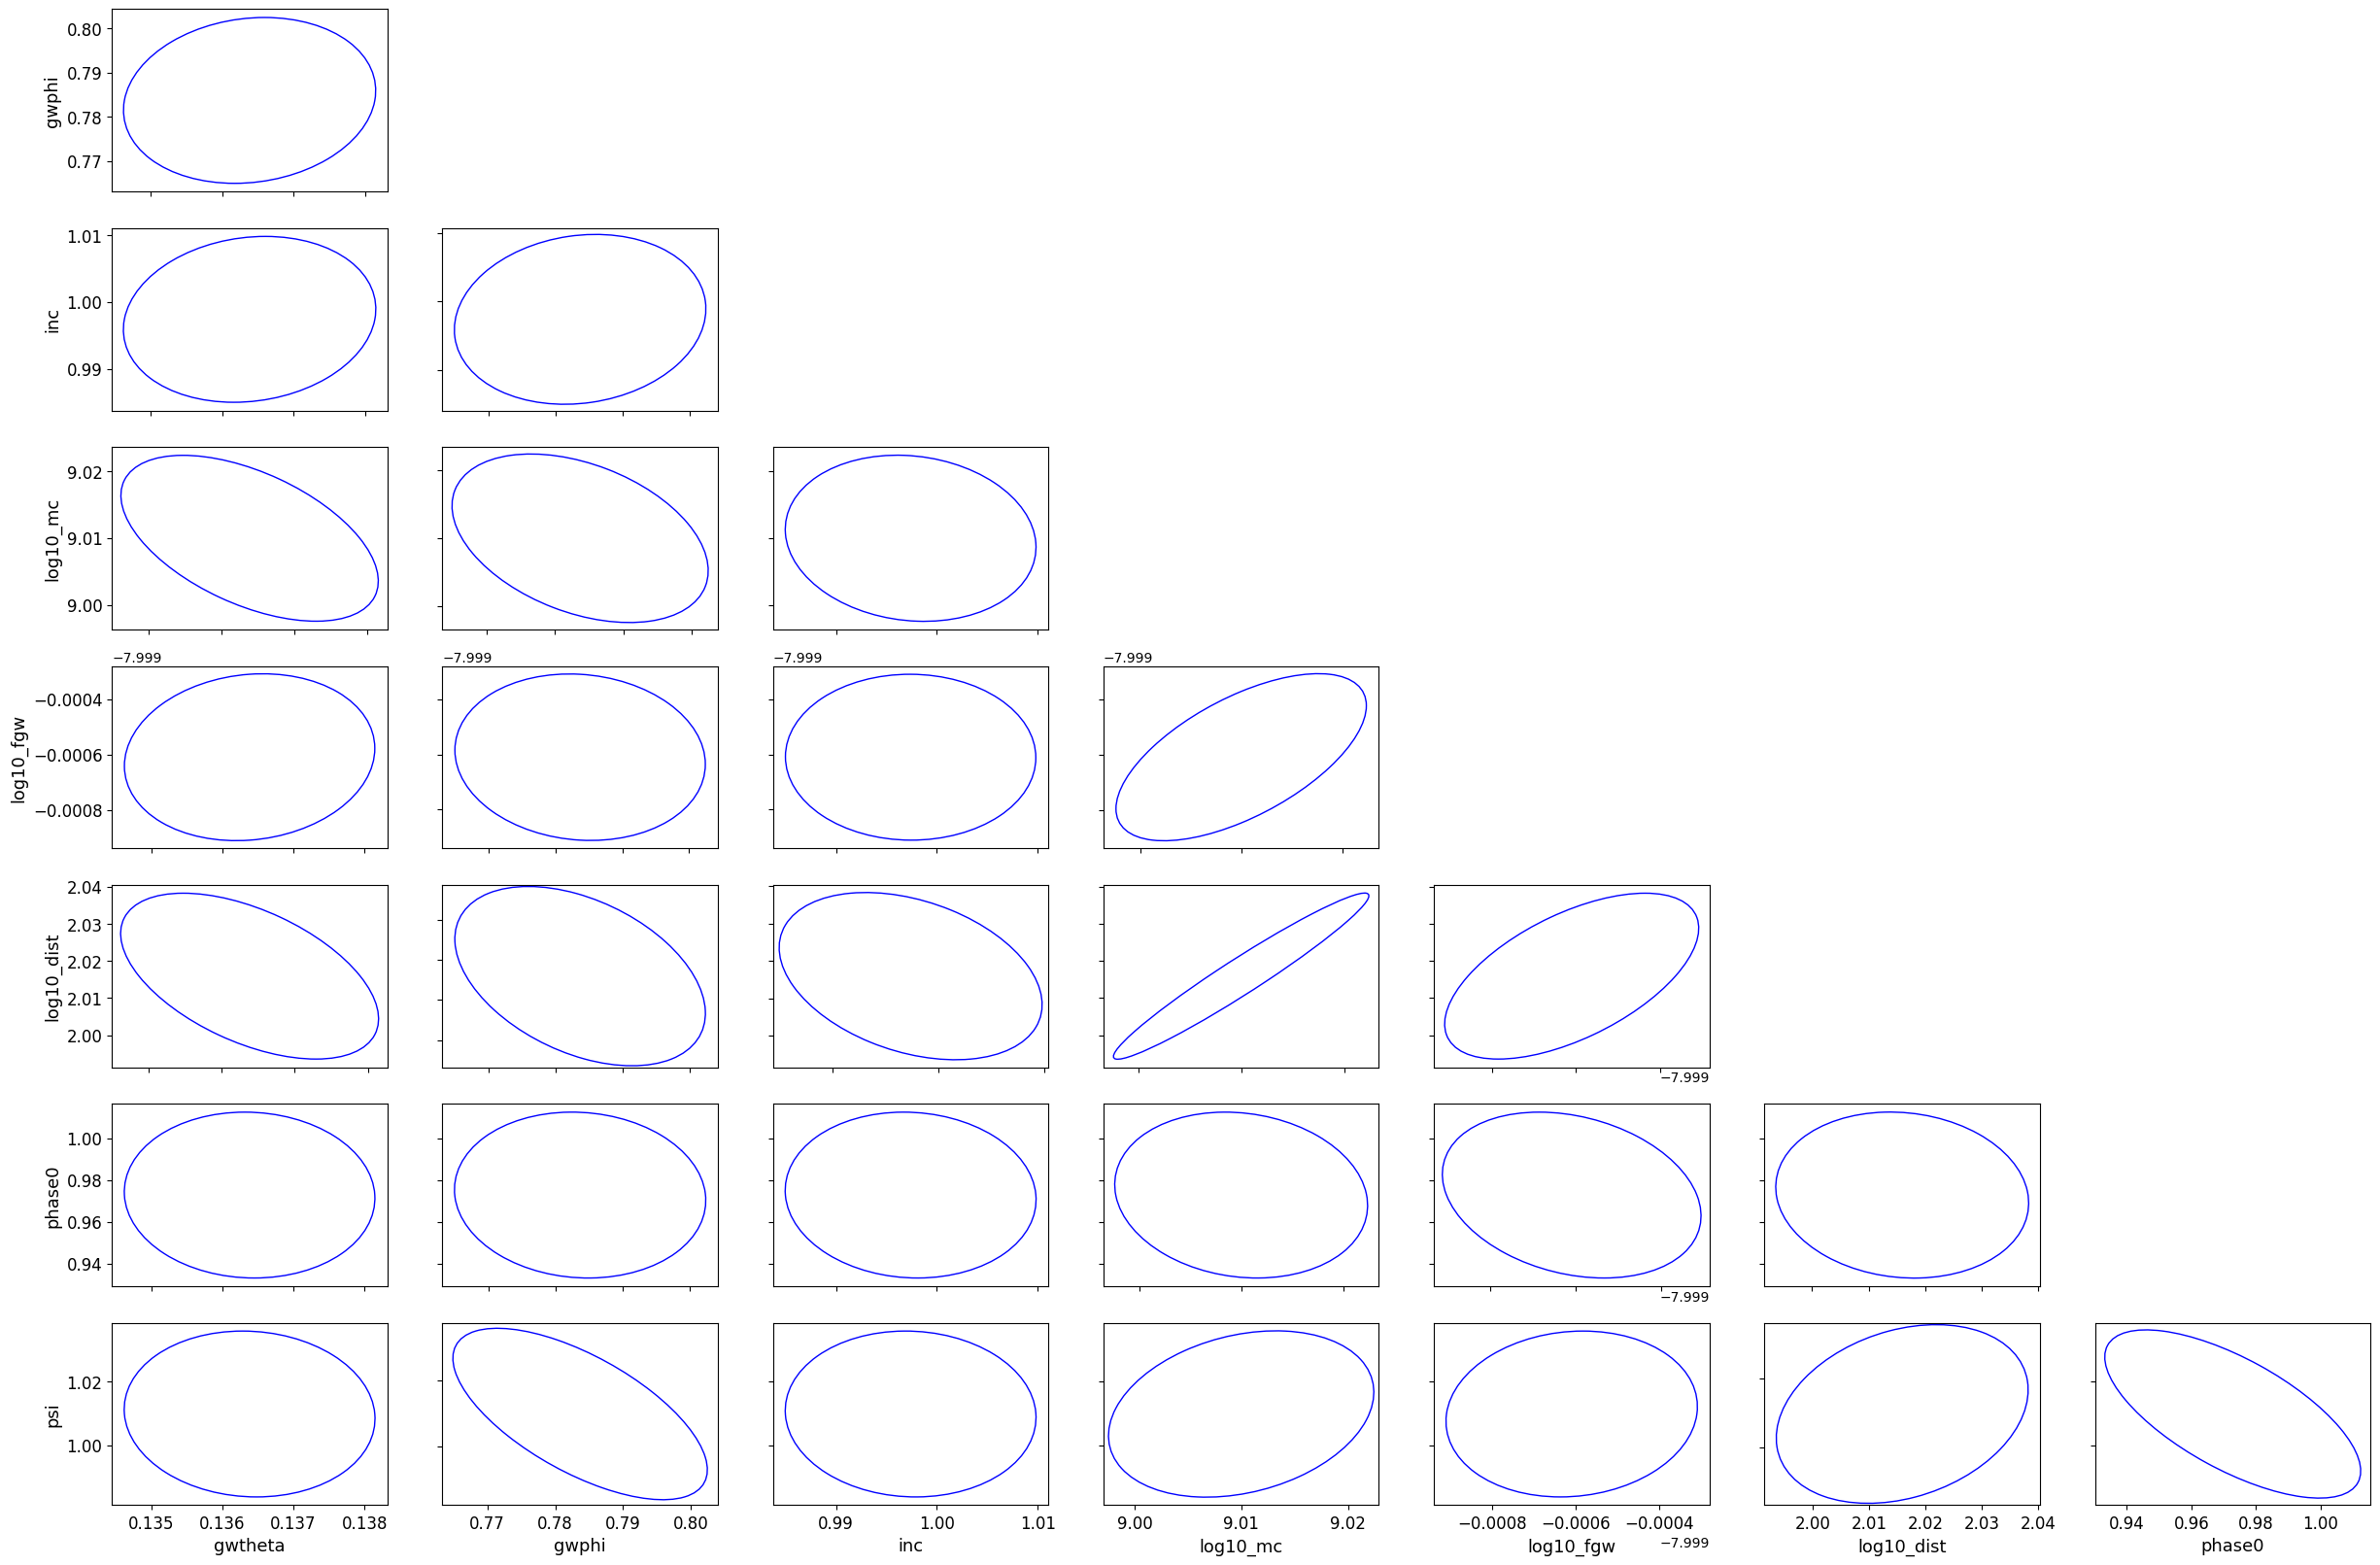

In [17]:
# Probability level used for confidence ellipses (e.g., 0.68 = 68%)
prob_contour = mpmath.mpf(0.68)

# List of parameter names used for plotting
figvar = np.array(list(params_dict.keys()))

# List of all variable names (GW parameters + pulsar distances)
allvar = np.array(list(params_dict.keys()) + list(pdists_dict.keys()))

# Prepare the plot area (a matrix of subplots for parameter pairs)
fig, ax = plt.subplots(len(figvar) - 1, len(figvar) - 1, figsize=(30, 20))  # corresponds to 6*5, 4*5

ellipses_list = []
# For each pair of parameters, draw the confidence ellipse
for var1, var2 in itertools.combinations(figvar, 2):
    # Select the mean and covariance to use (e.g., means[0], covs[0])
    mean = means[0]
    cov = covs[0]

    # Extract the relevant 2D section of the mean and covariance matrix
    mask = (allvar == str(var1)) | (allvar == str(var2))
    mean2d = mean[mask]
    cov2d = cov[mask][:, mask]

    # Reverse the order of the mean and variance if they do not match the order of var1 and var2.
    if np.all(np.where(allvar == str(var1)) > np.where(allvar == str(var2))):
        mean2d = mean2d[::-1]
        cov2d = cov2d[::-1, ::-1]

    # Calculate subplot indices for the current parameter pair
    xfigvar = figvar[:-1]
    yfigvar = figvar[1:]
    xind = np.where(xfigvar == var1)[0][0]
    yind = np.where(yfigvar == var2)[0][0]

    # Get ellipse parameters (width, height, angle) from the covariance matrix
    width, height, angle = pta_contour.get_ellipse_params_from_cov(cov2d)

    # Create the confidence ellipse (scaled by chi-squared value for the given probability)
    ellipse = Ellipse(
        xy=mean2d,
        width=width * pta_contour.prob_chisq(prob_contour),
        height=height * pta_contour.prob_chisq(prob_contour),
        angle=angle,
        facecolor="none",
        edgecolor="blue",
        alpha=1.0,
        zorder=2.0,
        lw=1.0,
    )

    # Add the ellipse to the corresponding subplot panel
    ax[yind, xind].add_patch(ellipse)
    ellipses_list.append(ellipse)

# Create a dictionary of mean values (for ArviZ visualization)
mean_plot = {figvar[i]: mean[i] for i in range(len(figvar))}

# Use ArviZ to generate a pair plot (visualizing the parameter space)
plot2d = az.plot_pair(
    mean_plot,
    var_names=figvar,
    textsize=12,
    scatter_kwargs={"alpha": 0},  # Hide scatter points to emphasize the ellipses
    ax=ax,
)
